In [23]:
import warnings
from collections import Counter
warnings.filterwarnings("ignore")

import pickle
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# https://sdv.dev/SDV/user_guides/single_table/ctgan.html
from ctgan import CTGANSynthesizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler


MODELS_PATH = './models'
DATA_PATH = './data/'
dataset = 'adult'
seed = 1
np.random.seed(seed)

In [3]:
# load adult
# https://towardsdatascience.com/logistic-regression-classifier-on-census-income-data-e1dbef0b5738
def load_adult():
    columns = ["age",
               "workClass", 
               "fnlwgt", 
               "education", 
               "education-num",
               "marital-status", 
               "occupation", 
               "relationship",
               "race", 
               "sex", 
               "capital-gain", 
               "capital-loss",
               "hours-per-week", 
               "native-country", 
               "income"]
    
    train = pd.read_csv(os.path.join(DATA_PATH, 'adult/data'), names=columns, sep=' *, *', na_values='?', engine='python')
    test = pd.read_csv(os.path.join(DATA_PATH, 'adult/test'), names=columns, sep=' *, *', skiprows=1, na_values='?', engine='python')

#     test['income'].replace(regex=True, inplace=True, to_replace=r'\.', value=r'')
#     adult = pd.concat([test,train])
#     adult.reset_index(inplace=True, drop=True)
#     return adult,
    return train, test, columns

In [4]:
train_data, test_data, discrete_columns = load_adult()    

In [5]:
train_data.shape

(32561, 15)

# Train CTGAN with confidence level and black-box model

### CTGAN code structure:
1. **transformer.py** - implements _Mode-specific Normalization_ to continuous values, while categorical are encoded with OHE.

2. **synthesizer.py** - main code, implements fit (training GAN), predict (sample data), save and load. 

3. **models.py** - file contains Discriminator, Generator and Residual models.

4. **sampler.py** - TODO

5. **conditional.py** - TODO

In [6]:
# load rf model
with open(os.path.join(MODELS_PATH, 'adult_rf_0.852.pkl'), 'rb') as rf_fd:
    rf_model = pickle.load(rf_fd)
    
# load rf pipeline
with open(os.path.join(MODELS_PATH, 'adult_rf_0.852_pipeline.pkl'), 'rb') as pl_fd:
    rf_pipeline = pickle.load(pl_fd)

In [7]:
def gen_random_noise(shape):
    mu = 0
    sigma = 1
    z = sigma * np.random.randn(*shape) + mu
    return pd.DataFrame(z)

def plot_losses(hist, title):
    plt.figure(figsize=(10,5))
    plt.grid()
    plt.title(title, fontsize=25)
    plt.plot(hist["loss_g"], '-o', label="loss_g", linewidth=2.0)
    plt.plot(hist["loss_bb"], '-o', label="loss_bb", linewidth=2.0)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel("Number of epochs", fontsize=20)
    plt.ylabel('Loss', fontsize=20)
    plt.legend(loc='upper right', fontsize=10)
    plt.show()

In [7]:
# ### losses check
# z = gen_random_noise(shape=(10000, 81))
# batch_size = 500
# epochs = 50
# confidence_level = 0.9 
# gen_lr = 2e-5
# losses = ['log', 'l1', 'l2']


# for loss in losses:
#     rf_ctgan = CTGANSynthesizer(batch_size=batch_size, 
#                                 blackbox_model=rf_model, 
#                                 preprocessing_pipeline=rf_pipeline, 
#                                 bb_loss=loss
#                                 )

#     hist = rf_ctgan.fit(train_data=z, 
#                         epochs=epochs,
#                         confidence_level=confidence_level,
#                         gen_lr=gen_lr,
#                         )
#     plot_losses(hist, title=loss + ' loss')
#     print()

In [8]:
# # confidence levels check
# z = gen_random_noise(shape=(10000, 81))
# batch_size = 500
# epochs = 50
# gen_lr = 2e-5
# loss = 'log'
# confidence_levels = [0.7, 0.8, 0.9]
# # confidence_levels = [0.7]

# for c in confidence_levels:
#     rf_ctgan = CTGANSynthesizer(batch_size=batch_size, 
#                                 blackbox_model=rf_model, 
#                                 preprocessing_pipeline=rf_pipeline, 
#                                 bb_loss=loss
#                                 )

#     hist = rf_ctgan.fit(train_data=z, 
#                         epochs=epochs,
#                         confidence_level=c,
#                         gen_lr=gen_lr,
#                         )
    
#     rf_ctgan.save(f"ctgan_c_{c}.pkl")
#     plot_losses(hist, title=f"confidence level = {c}")
    

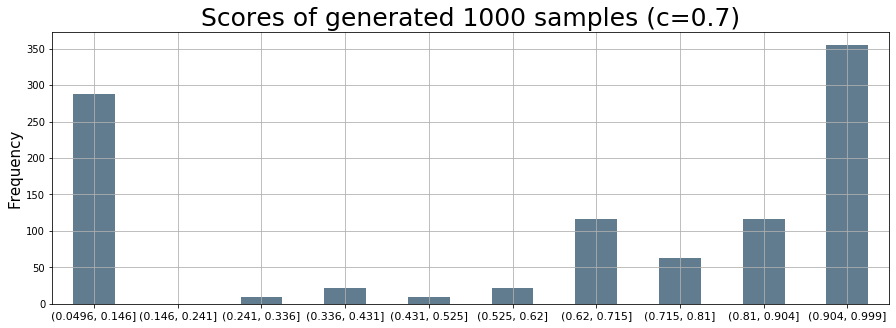

In [11]:
#  check confidence for the generated samples
samples = 1000
# confidence_levels = [0.7, 0.8, 0.9]
confidence_levels = [0.7]

for c in confidence_levels:
    rf_ctgan = CTGANSynthesizer.load(f"{MODELS_PATH}/ctgan_c_{c}.pkl") 
    test_data = rf_ctgan.sample(samples)
    y_prob = rf_model.predict_proba(test_data)
    y_conf_gen = y_prob[:, 0]  # confidence scores
    
    counts = pd.value_counts(y_conf_gen, bins=10, sort=False)
    plt.figure()
    ax = counts.plot.bar(rot=0, grid=True, color='#607c8e', figsize=(15,5))
    ax.set_xticklabels([str(interval) for interval in counts.index], fontsize=11)
    ax.set_ylabel('Frequency', fontsize=15)

    ax.set_title(f'Scores of generated 1000 samples (c={c})', fontsize=25)

In [16]:
test_data.shape

(1000, 81)